# (08) Reservoir + GLM

**Motivation**: Very competetive models with Resrvoir + GLM. This notebook: ```expt=clu096```.

## Approach:
1. STA
2. find best_lag
3. at best_lag, find best $(i, j)$
4. Additionally, you can find best filters as well.
5. Finally, fit a GLM at best-lag and best $(i, j)$ using all or a subset of filters.
<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from torch.nn import functional as F
from sklearn.decomposition import PCA
from analysis.linear import LinearModel, flatten_stim
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

## Load neuron

In [3]:
cfg = ConfigVAE(save=False)
file = h5py.File(cfg.h_file, 'r')
expt = 'clu096'
grp = file[expt]

In [4]:
scale = 2.25
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
good = ~np.array(grp['badspks'])
good = np.where(good)[0]

# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)

stim_scale = np.max(np.abs(stim))
stim *= scale / stim_scale
if stim_r is not None:
    stim_r *= scale / stim_scale

stim.shape, stim_r.shape

((28800, 2, 19, 19), (12000, 2, 19, 19))

## Reservoir

In [5]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(model=vae, cfg=ConfigTrainVAE(batch_size=300), device='cuda:1')
vae.cfg.total_latents()

210

In [6]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

### Extract features

In [7]:
from readout.readout import process_ftrs

kws_process = dict(
    scale=4,
    pool='max',
    act_fn='swish',
)

In [8]:
# Stim
enc = []
for i in tqdm(range(int(np.ceil(len(stim) / tr.cfg.batch_size)))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim))
    *_, ftr = tr.model_ema.xtract_ftr(
        x=tr.to(stim[a:b]), full=True)
    ftr = process_ftrs(ftr['enc'], **kws_process)
    ftr = torch.cat(list(ftr.values()), dim=1)
    enc.append(to_np(ftr))
enc = np.concatenate(enc)

enc_r = []
for i in range(int(np.ceil(1000 / tr.cfg.batch_size))):
    a = i * tr.cfg.batch_size
    b = min(a + tr.cfg.batch_size, len(stim_r))
    *_, ftr = tr.model_ema.xtract_ftr(
        x=tr.to(stim_r[a:b]), full=True)
    ftr = process_ftrs(ftr['enc'], **kws_process)
    ftr = torch.cat(list(ftr.values()), dim=1)
    enc_r.append(to_np(ftr))
enc_r = np.concatenate(enc_r)

enc.shape, enc_r.shape

100%|██████████| 96/96 [00:21<00:00,  4.53it/s]


((28800, 5312, 4, 4), (1200, 5312, 4, 4))

In [9]:
mu, sd = enc.mean(), enc.std()
mu, sd

(0.026566723, 0.12153089)

In [10]:
enc = (enc - mu) / sd
enc_r = (enc_r - mu) / sd

In [11]:
mu_ch = np.mean(enc, axis=(0, 2, 3))
sd_ch = np.std(enc, axis=(0, 2, 3))

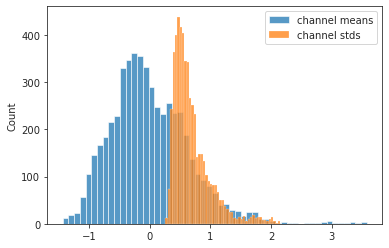

In [12]:
sns.histplot(mu_ch, label='channel means')
sns.histplot(sd_ch, color='C1', label='channel stds')
plt.legend();

## Select best pix/lag using STA

In [13]:
from analysis.linear import compute_sta

In [14]:
lags = 29
sta = compute_sta(
    lags=lags,
    good=good,
    stim=enc,
    spks=spks,
    zscore=True,
    verbose=True,
)
sta.shape

100%|██████████| 24270/24270 [06:54<00:00, 58.49it/s]


(1, 30, 5312, 4, 4)

In [73]:
enc.shape, spks.shape, len(good)

((28800, 5312, 4, 4), (28800, 1), 24280)

In [74]:
sta.mean(), sta.std()

(0.008055165333618683, 0.09905146851923409)

In [98]:
dims = (2, 3, 4)
norm = np.mean(sta ** 2, axis=dims)
best_lag = np.argmax(norm[:, -5:][:, ::-1], axis=1)
norm.shape

(1, 30)

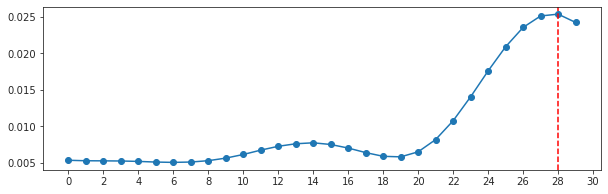

In [99]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(norm[0], marker='o')
plt.axvline(lags - best_lag[0], color='r', ls='--')
ax.locator_params(axis='x', nbins=25)

In [100]:
sta.shape

(1, 30, 5312, 4, 4)

In [101]:
dims = (1, 3, 4)
norm = np.mean(sta ** 2, axis=dims)

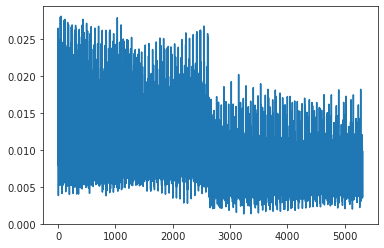

In [102]:
plt.plot(norm[0]);

In [103]:
best_filts = np.argsort(norm[0])[::-1]
best_filts[0]

52

In [107]:
dims = (1, 2)
norm = np.mean(sta ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm[0]), (4, 4))
best_i, best_j

(0, 3)

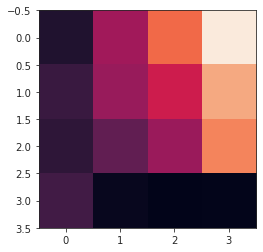

In [108]:
plt.imshow(norm[0])

### Top 300 filters + 12 lags

In [110]:
src = time_embed(enc[:, best_filts[:300], best_i, best_j], lags=12, idxs=good)
src_r = time_embed(enc_r[:, best_filts[:300], best_i, best_j], lags=12, idxs=intvl)
src.shape, src_r.shape

((24280, 12, 300), (200, 12, 300))

In [111]:
%%time

neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=src,
    y=spks[idxs, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[1e-3, 1e-2, 1e-1, 1, 10],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

CPU times: user 1h 18min 27s, sys: 12min 10s, total: 1h 30min 38s
Wall time: 19min 26s


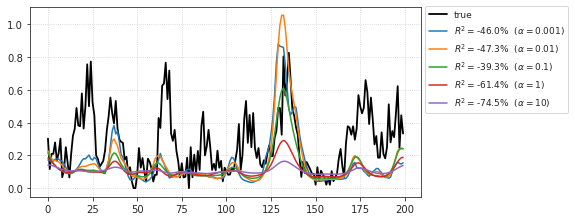

In [112]:
glm.show_pred();

In [113]:
glm.r_tst

{0.001: 0.4051818504804795,
 0.01: 0.43707450694587946,
 0.1: 0.4594394683711419,
 1: 0.4504742723635018,
 10: 0.4382929960451283}

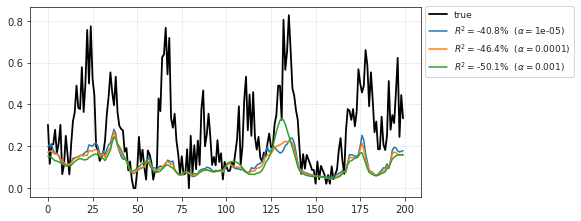

{1e-05: 0.5545133275942643,
 0.0001: 0.5683477068492214,
 0.001: 0.5162038482820526}

### Now all filters, but at max lag

In [115]:
sta.shape

(1, 30, 5312, 4, 4)

In [118]:
dims = (0,)
norm = sta[0, best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm), norm.shape)
best_i, best_j

(0, 3)

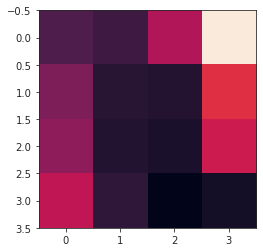

In [119]:
plt.imshow(norm)

In [125]:
x = enc[idxs - best_lag[0], :, best_i, best_j]
x_tst = enc_r[intvl - best_lag[0], :, best_i, best_j]
x.shape, x_tst.shape

((24280, 5312), (200, 5312))

In [126]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=x,
    y=spks[idxs, neuron_i],
    x_tst=x_tst,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[5e-3, 1e-2, 5e-2, 1e-1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

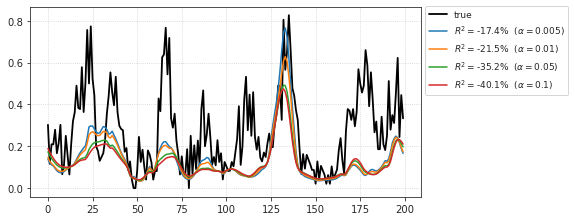

In [127]:
glm.show_pred();

In [128]:
glm.r_tst

{0.005: 0.5812316118628275,
 0.01: 0.5829543712002115,
 0.05: 0.55011559255433,
 0.1: 0.5314278087525216}

## Zscored features?

In [133]:
mu = x.mean(0, keepdims=True)
sd = x.std(0, keepdims=True)

In [134]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=(x - mu) / sd,
    y=spks[idxs, neuron_i],
    x_tst=(x_tst - mu) / sd,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[5e-3, 1e-2, 5e-2, 1e-1, 1, 10, 100],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

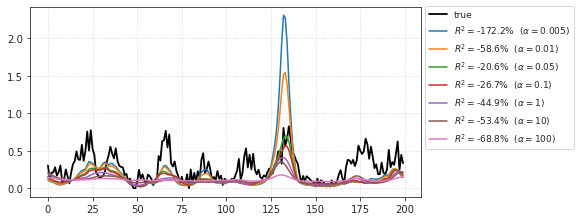

In [135]:
glm.show_pred();

In [136]:
glm.r_tst

{0.005: 0.495152367570329,
 0.01: 0.5326852701669722,
 0.05: 0.5867188772056051,
 0.1: 0.5842036467783142,
 1: 0.5303149101141236,
 10: 0.4781822852733906,
 100: 0.4517347920040796}